In [1]:
import locale
# Set to German locale to get comma decimal separater
locale.setlocale(locale.LC_NUMERIC, "de_DE.UTF-8")

import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import scienceplots
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from matplotlib.backends.backend_pgf import FigureCanvasPgf

matplotlib.backend_bases.register_backend('pdf', FigureCanvasPgf)

plt.rcParams['axes.formatter.use_locale'] = True

# use fancy style and tex in plt
plt.style.use(['science', 'russian-font'])
matplotlib.rc('text', usetex = True)
preamble = plt.rcParams.get('text.latex.preamble')
params = {
  'pgf.rcfonts' : False,
  'pgf.texsystem' : 'pdflatex',
  'pgf.preamble' : "\n".join([preamble,r'\usepackage{textcomp,mathcomp}'])

}
plt.rcParams.update(params)
plt.rcParams.update({"axes.grid" : True, "grid.linestyle" : (0, (5, 10))})

np.random.seed(0)

import os
current_dir = os.getcwd().lower()

OUTPUT_DIR = 'processor_output'
# Create output folder if it does not exist
if (not os.path.exists(f'./{OUTPUT_DIR}')):
    os.makedirs(OUTPUT_DIR)

In [35]:
TEMP_ERR = 0.2
PRESS_ERR = 0.1
VOLT_ERR = 2

Cp = 37.1
R = 8.31

In [3]:
lab_data = pd.read_csv('data.csv')
lab_data['volt'] = -lab_data['volt']
sense_data = pd.read_csv('sensetivity.csv')

In [85]:
import itertools
import math
def gen_bars(df, col, err):
  df = df.copy()
  df[col+'_hb'] = df[col] + err
  df[col+'_lb'] = df[col] - err
  return df

def gen_col_with_bars(df, col, func, *params):
  lb = pd.Series([math.inf] * len(df), index=df.index)
  hb = pd.Series([-math.inf] * len(df), index=df.index)
  for i in itertools.product(*[[col+'_hb', col+'_lb'] for col in params]):
    val = df.apply(lambda x: func(**{key[:-3]: x[key] for key in i}), axis=1)
    lb = np.minimum(lb, val)
    hb = np.maximum(hb, val)
  df = df.copy()
  df[col] = df.apply(lambda x: func(**{key: x[key] for key in params}), axis=1)
  df[col+'_hb'] = hb
  df[col+'_lb'] = lb
  return df

In [5]:
lab_data = gen_bars(lab_data, 'temp', TEMP_ERR)
lab_data = gen_bars(lab_data, 'volt', VOLT_ERR)
lab_data = gen_bars(lab_data, 'press', PRESS_ERR)

In [6]:

def get_sense(temp):
  return np.interp(temp, sense_data.temp, sense_data.sense)

def get_temp_diff(temp, volt):
  return volt / get_sense(temp)

lab_data = gen_col_with_bars(lab_data, 'tempdiff', get_temp_diff, 'volt', 'temp')

In [7]:
def get_errs(df, col):
  return np.vstack((df[col+'_hb'] - df[col],  df[col] - df[col+'_lb']))

In [8]:
def plot_press_temp(ax, df, label):
  y = df.tempdiff
  x = df.press
  yerr = get_errs(df, 'tempdiff')
  xerr = get_errs(df, 'press')

  p = np.poly1d(np.polyfit(x, y, 1))

  xp = np.linspace(x.min(), x.max(), 100)

  sc, = ax.plot(xp, p(xp), label=label)
  ax.scatter(x, y, s=10, zorder=10, c=sc.get_color())
  ax.errorbar(x, y, yerr=yerr, xerr=xerr, ls='None', ecolor=sc.get_color(),
              capsize=3, c=sc.get_color())

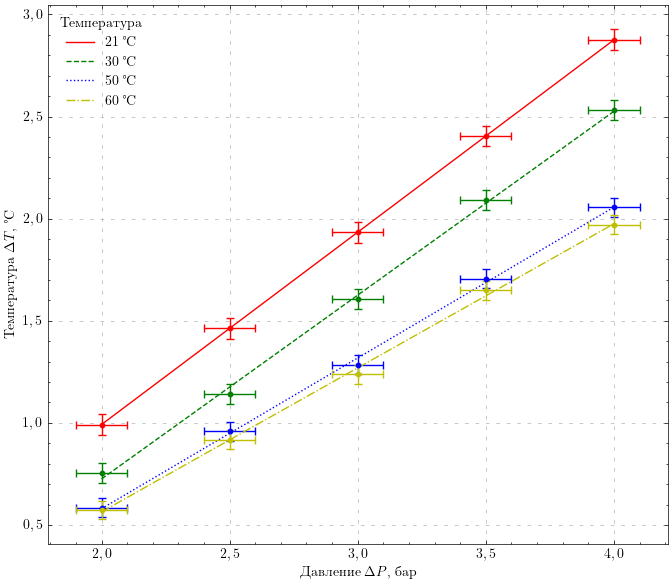

In [9]:
from cycler import cycler

fig, ax = plt.subplots(figsize=(8, 7))
custom_cycler = (cycler(color=['r', 'g', 'b', 'y', 'g', 'y']) +
                cycler(linestyle=['-', '--', ':', '-.', ':', '-.']))
ax.set_prop_cycle(custom_cycler)

for name, group in lab_data.groupby('temp'):
  plot_press_temp(ax, group, f'{name} \\textcelsius')
plt.xlabel(f'Давление $\Delta P$, бар')
plt.ylabel(f'Температура $\Delta T$, \\textcelsius')
plt.legend(title='Температура')
plt.savefig(f'{OUTPUT_DIR}/press_temp.pgf')

In [10]:
def to_rus_str(col):
  return col.astype('str').str.replace('.', ',')

def gen_latex_col(df, col, round, err=None):
  if round > 0:
    fround = lambda x: x.round(round)
  else:
    fround = lambda x: x.astype(int)

  if err is None:
    err = (df[col+'_hb'] - df[col+'_lb']) / 2
  err = to_rus_str(fround(err))
  newcol = to_rus_str(fround(df[col]))
  return "$" + newcol + " \pm " + err + "$"


def gen_measure_tbl(df, temp, index):
  columns = [
      r'$\Delta P$, бар',
      r'$\Delta U$, мкВ',
      r'$\Delta T$, \textcelsius'
    ]
  new = pd.concat(
    [
      gen_latex_col(df, 'press', 1)[::-1],
      gen_latex_col(df, 'volt', 0)[::-1],
      gen_latex_col(df, 'tempdiff', 2)[::-1]
    ], axis=1)
  new.columns = pd.MultiIndex.from_product([[r'Температура $T$ = '+str(temp)+r'\textcelsius'], columns])
  return new.to_latex(index_names=False,
                      index=False,
                      buf=f'{OUTPUT_DIR}/tbl_meas_{index}.tex',
                      column_format='ccc',
                      multicolumn_format='c')


In [11]:
for i, (temp, group) in enumerate(lab_data.groupby('temp')):
  gen_measure_tbl(group, temp, i)

In [84]:
def get_err_from_bars(df, col):
  return (df[col+'_hb'] - df[col+'_lb']) / 2

def get_random_sample(df, column, err=None):
  if err is None:
    return np.random.normal(df[column], (df[column+'_hb'] - df[column+'_lb']) / 2)
  else:
    return np.random.normal(df[column], err)

def simulate(df, xcol, ycol, num=1000, xerr=None, yerr=None):
  np.random.seed(0)
  slopes = []
  intercepts = []
  for i in range(num):
    x = get_random_sample(df, xcol, err=xerr)
    y = get_random_sample(df, ycol, err=yerr)

    coef = np.polyfit(x, y, 1)
    slopes.append(coef[0])
    intercepts.append(coef[1])

  return np.array(slopes), np.array(intercepts)

def get_slopes_stat(df, xcol, ycol):
  slopes, _ = simulate(df, xcol, ycol)
  return {'mean': np.mean(slopes), 'std': np.std(slopes)}

def get_sim_stat(df, xcol, ycol, xerr=None, yerr=None):
  slopes, intercepts = simulate(df, xcol, ycol, xerr=xerr, yerr=yerr)
  return {
    'slopes': {'mean': np.mean(slopes), 'std': np.std(slopes)},
    'intercepts': {'mean': np.mean(intercepts), 'std': np.std(intercepts)}
  }

In [13]:
mujt = lab_data.groupby('temp').apply(lambda x: pd.Series(get_slopes_stat(x, 'press', 'tempdiff')), include_groups=False)

In [14]:
mujt = mujt.reset_index()

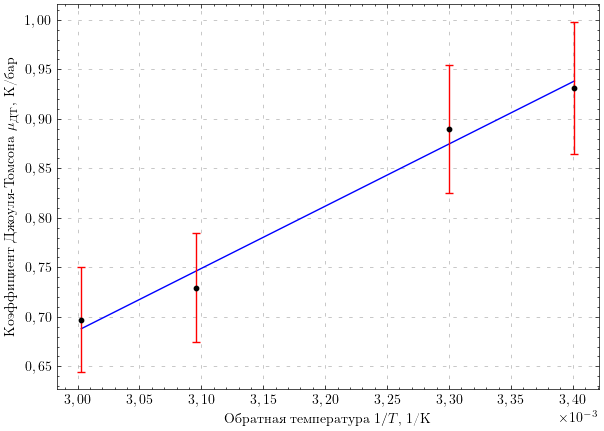

In [53]:
import locale

locale.setlocale(locale.LC_ALL, "de_DE.UTF-8")


def plot_mujt(ax, df):
  y = df['mean']
  x = 1 / (df.temp + 273)
  yerr = df['std']

  p = np.poly1d(np.polyfit(x, y, 1))

  xp = np.linspace(x.min(), x.max(), 100)

  sc, = ax.plot(xp, p(xp), c='b')
  ax.scatter(x, y, s=10, zorder=10, c='black')
  ax.errorbar(x, y, yerr=yerr, ls='None', ecolor='r',
              capsize=3)

fig, ax = plt.subplots(figsize=(7, 5))
plot_mujt(ax, mujt)
ax.ticklabel_format(style='sci', axis='x', scilimits=(3, 4))
plt.xlabel(r'Обратная температура $1/T$, 1/K')
plt.ylabel(r'Коэффициент Джоуля-Томсона $\mu_{\text{ДТ}}$, К/бар')
plt.savefig(f'{OUTPUT_DIR}/mujt.pgf')

In [26]:
def gen_mujt_tbl(df):
  new = pd.concat(
    [
      df.temp,
      gen_latex_col(df, 'mean', 2, df['std'])
    ], axis=1)
  new.columns = [
      r'$T$, \textcelsius',
      r'$\mu_{\text{ДТ}}$, K/бар'
    ]
  new = new.set_index(new.columns[0])

  return new.T.to_latex(buf=f'{OUTPUT_DIR}/tbl_mujt.tex',
                      column_format='c' * (len(new) + 1),
                      multicolumn_format='c')

gen_mujt_tbl(mujt)

In [32]:
mujt['invtemp'] = 1 / (mujt.temp + 273)
vdv_stat = pd.DataFrame(get_sim_stat(mujt, 'invtemp', 'mean', xerr=0, yerr=mujt['std']))

In [77]:
def get_vdv_a(coef):
  return Cp * R / 2 * coef / 10e5

def get_vdv_b(coef):
  return - Cp * coef / 10e5

vdv_stat['a'] = vdv_stat.slopes.apply(get_vdv_a)
vdv_stat['b'] = vdv_stat.intercepts.apply(get_vdv_b)
vdv_stat.style.format({'a': '{:.1E}', 'b': '{:.1E}'})

,slopes,intercepts,a,b
mean,626.462354,-1.195311,9.7E-02,4.4E-05
std,188.313715,0.597821,2.9E-02,-2.2E-05


In [89]:
def get_tinv(a, b):
  return 2 * a / R / b

a = vdv_stat.loc['mean', 'a']
aerr = vdv_stat.loc['std', 'a']
b = vdv_stat.loc['mean', 'b']
berr = vdv_stat.loc['std', 'b']

vdv_stat_new = vdv_stat.loc['mean', ['a', 'b']].to_frame().T
vdv_stat_new = gen_bars(vdv_stat_new, 'a', aerr)
vdv_stat_new = gen_bars(vdv_stat_new, 'b', berr)
vdv_stat_new = gen_col_with_bars(vdv_stat_new, 'tinv', get_tinv, 'a', 'b')
vdv_stat_new

,a,b,a_hb,a_lb,b_hb,b_lb,tinv,tinv_hb,tinv_lb
mean,0.096569,0.000044,0.125598,0.067541,0.000022,0.000067,524.100093,1363.665172,244.348342


In [90]:
get_err_from_bars(vdv_stat_new, 'tinv')

mean    559.658415
dtype: float64

In [93]:
tcrit = vdv_stat_new[vdv_stat_new.columns[-3:]] * 4 / 27
tcrit

,tinv,tinv_hb,tinv_lb
mean,77.644458,202.02447,36.199754


In [94]:
# critical temp
get_err_from_bars(tcrit, 'tinv')

mean    82.912358
dtype: float64